
# Projet 9 : prédiction des consommations d'électricité.



Dans ce projet, nous allons essayer de prédire la consommation d'électricité en France.



# Mission 1
## Correction

__Corrigez les données de consommation mensuelle étude de l'effet température (due au chauffage électrique) en utilisant une régression linéaire.__

Dans cette partie, nous allons corriger nos données, de l'effet température, grâce au DJU.
Tout d'abord qu'est ce que les DJU ?

Les degrés jours unifiés, sont des valeurs représentatives de la température d'une journée et de son écart avec un seuil de température préétabli (18° dans le cas des DJU)
Cela nous permet en résumer de voir si lors d'une période, il a fait plus froid ou non.

Nous voulons ici nous en servir pour corriger les données de consommation, nous pourrons comparer nos différents mois entre eux.

Pour un exemple concret, imaginons deux mois de janvier. Nous aurons des chiffres de consommation. Mais si nous ne prenons pas en compte les températures durant ces mois-ci, nous ne pourrons pas voir si la consommation a augmenté. Nous verrons juste les piques dus au froid et à l'augmentation de l'usage du chauffage électrique.



In [1]:

#import des librairies

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox


pd.set_option('display.float_format','{:.3f}'.format)
%matplotlib inline 

destination_graph = "img_graph/"


In [2]:

#Import données
path_consommation = "Data/set_consoMensuFrance.csv"
path_djuMensu = "Data/set_DjuMoyenFrance.csv"

df_ConsoMensuFrance = pd.read_csv(path_consommation,parse_dates=[0], dayfirst=True, index_col="Date")
df_DjuMoyFrance = pd.read_csv(path_djuMensu,parse_dates=[0], dayfirst=True, index_col="Date")


Visualisation des données.

In [3]:

#Consommation électrique en France, (kWh)
df_ConsoMensuFrance = df_ConsoMensuFrance.drop(columns="Region")
# df_ConsoMensuFrance = df_ConsoMensuFrance.drop(df_ConsoMensuFrance[df_ConsoMensuFrance.index.year == 2019].index)
df_ConsoMensuFrance.head()


,Consommation
Date,
2010-01-01,56342
2010-02-01,48698
2010-03-01,48294
2010-04-01,38637
2010-05-01,37284


In [4]:
df_ConsoMensuFrance.tail()

,Consommation
Date,
2019-04-01,37779
2019-05-01,35454
2019-06-01,32519
2019-07-01,34388
2019-08-01,31538


In [5]:

#Dju mensuel France
df_DjuMoyFrance = df_DjuMoyFrance[df_DjuMoyFrance.index.isin(df_ConsoMensuFrance.index)]
df_DjuMoyFrance.head()


,Dju
Date,
2010-01-01,460.385
2010-02-01,352.462
2010-03-01,305.077
2010-04-01,180.692
2010-05-01,140.231


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb4069688d0>]],
      dtype=object)

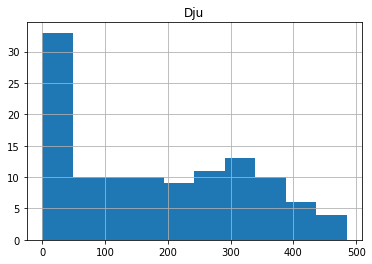

In [6]:

df_DjuMoyFrance.hist()


### Représentation de la série temporelle

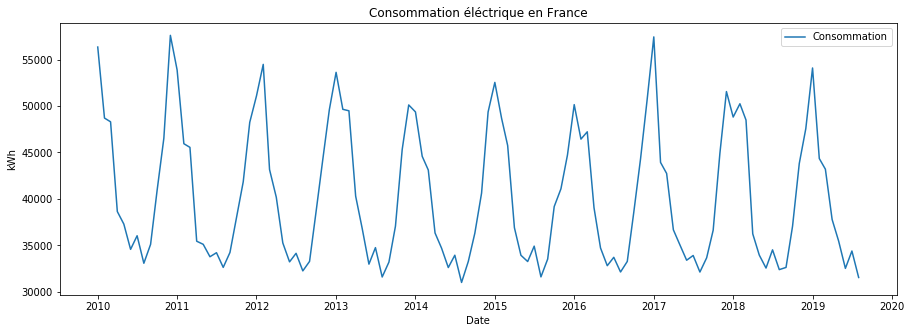

In [7]:

#Représentation des données
plt.figure(figsize=(15,5))
plt.plot(df_ConsoMensuFrance, label='Consommation')
plt.title("Consommation éléctrique en France")
plt.ylabel("kWh")
plt.xlabel("Date")
plt.legend()
plt.savefig(destination_graph+"donnéeBrut.png")
plt.show()



On peut voir ici que nos consommations ont de grosse augmentation en hiver, due au chauffage électrique entre autres.



# Mission 1
## Correction des données

Nous allons donc essayer de corriger nos données de cet effet saisonnier, grâce à une régression linéaire.


In [8]:

regression_x = df_ConsoMensuFrance.reset_index()
regression_y = df_DjuMoyFrance.reset_index()


regression_x.Date = pd.to_datetime(regression_y.Date)
regression_x.Date = pd.to_datetime(regression_y.Date)


In [9]:

# Pour chaque mois on va créer un coefficient de correction à l'aide d'une régression entre les consommations et les DJU

#Dataframe pour nos coefficients
df_coef = pd.DataFrame()

i=1

while i < 13:
    
    #Sélection des données pour un mois en particulier sur plusieurs années.
    mois = i
    tempo_X = regression_x[regression_x.Date.dt.month == mois]
    tempo_Y = regression_y[regression_y.Date.dt.month == mois]
    
    
    #Régression où X est notre variable explicative et Y est notre variable expliquée
    slope, intercept, r_value, p_value, std_err = st.linregress(tempo_X.Consommation, tempo_Y.Dju)
    
    #Coefficient de régression
    coef_actuel = slope
    
    df_coef = df_coef.append({"Mois":i,"Coef":coef_actuel}, ignore_index=True)

    i+=1

df_coef.head()


,Coef,Mois
0,0.019,1.000
1,0.020,2.000
2,0.012,3.000
3,0.019,4.000
4,0.020,5.000


In [10]:

#On corrige maintenant nos données avec nos coefficients

df_ConsoMensuFrance_Corriger = pd.DataFrame()

for i,r in regression_x.iterrows():

    
    mois_actuel = r.Date.month 
    coef_actuel = df_coef[df_coef.Mois == mois_actuel].Coef
    conso_actuel = r.Consommation
    date_actuel = r.Date
    
    #Correction des données
    conso_cori = conso_actuel - conso_actuel*coef_actuel
    
    #Récupération des données corrigées
    df_ConsoMensuFrance_Corriger = df_ConsoMensuFrance_Corriger.append({"Date":date_actuel, "Consommation":conso_cori.values[0]},ignore_index = True)
    
df_ConsoMensuFrance_Corriger.set_index("Date", inplace = True)
regression_x.set_index("Date", inplace=True)
   

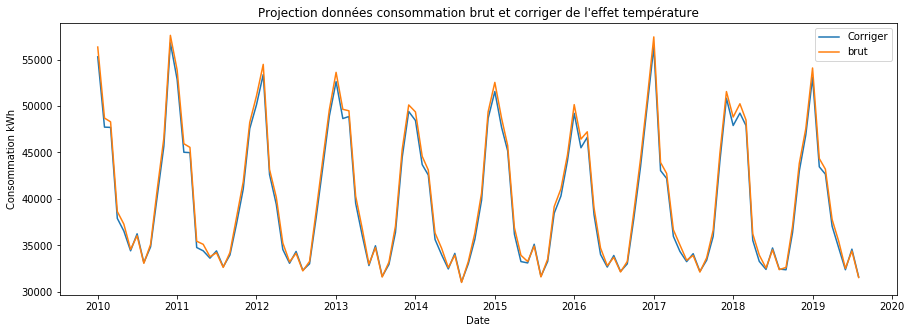

In [11]:

#Visualisation

plt.figure(figsize=(15,5))
plt.plot(df_ConsoMensuFrance_Corriger, label='Corriger')
plt.plot(df_ConsoMensuFrance, label='brut')
plt.xlabel("Date")
plt.ylabel("Consommation kWh")
plt.title("Projection données consommation brut et corriger de l'effet température")
plt.legend()
plt.savefig(destination_graph+"donnéeBrutEtCorrigertemperature.png")
plt.show()



La correction n'a pas eu un grand impact sur nos données, mais on peut tout de même voir des changements, certaines diminutions par exemple sur l'hiver 2016 ou 2018.


# Mission 2
## Désaisonnalisation

__Effectuez une désaisonnalisation de la consommation que vous aurez obtenu après correction, grâce aux moyennes mobiles.__

Nous voulons à présent venir de bout de l'effet de saison qui habite nos données.

Nos données varient en suivant un cycle prévisible, ici une période de l'année, par exemple en hiver, nos données ont une tendance à augmenter, c'est qu'on appelle une saisonnalité au sein des données.

Ce phénomène périodique, lié aux saisons, ne nous permet pas d'avoir une vision globale du comportement de la consommation, on ne voit pas si en globalité les consommations ont été plus élevées en 2015 qu'en 2016 par exemple, c'est pourquoi, nous allons tenter de désaisonnaliser ces données en utilisant le principe des moyennes glissantes.


In [12]:
#Fonction de lissage des données
def lissage(Lx,Ly,p):
    '''Fonction qui débruite une courbe par une moyenne glissante
    sur 2P+1 points'''
    Lxout=[]
    Lyout=[]
    Lxout = Lx[p: -p]
    for index in range(p, len(Ly)-p):
        average = np.mean(Ly[index-p : index+p])
        Lyout.append(average)
    return Lxout,Lyout



La fonction ci-dessus reprend le principe des moyennes glissantes, nous faisons une moyenne d'un point par rapport aux points qui l'entourent. Ici, notre fonction prendra *p* points avant et après le point et en fera une moyenne. 


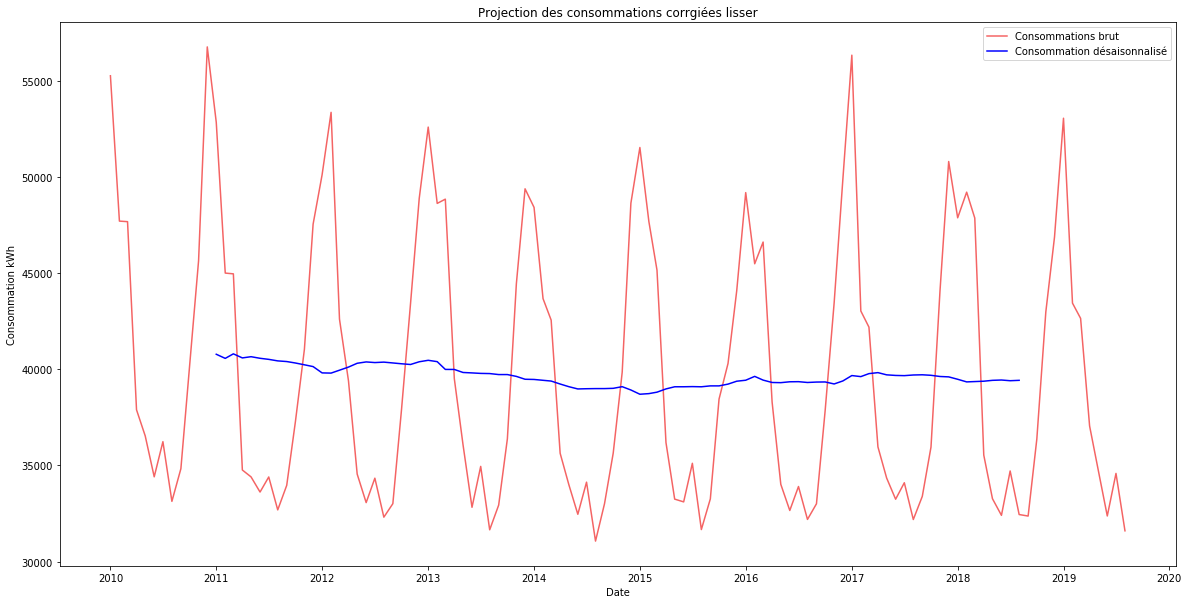

In [13]:

#Pas de 12, pour les 12 mois(saison)
degreLiss = 12

#Application de la fonction
data_liss, conso_liss = lissage(df_ConsoMensuFrance_Corriger.index,df_ConsoMensuFrance_Corriger['Consommation'],degreLiss)


#Représentation grahique avec les données brutes
plt.figure(figsize=(20,10))
plt.title("Projection des consommations corrgiées lisser")

plt.plot(df_ConsoMensuFrance_Corriger.index, df_ConsoMensuFrance_Corriger['Consommation'], label="Consommations brut", color="#f23d3d", alpha=0.8,)

plt.plot(data_liss,conso_liss,label="Consommation désaisonnalisé", color="blue")


plt.ylabel("Consommation kWh")
plt.xlabel("Date")
plt.legend()
plt.savefig(destination_graph+"donnéeBrutEtDesaiso.png")
plt.show()


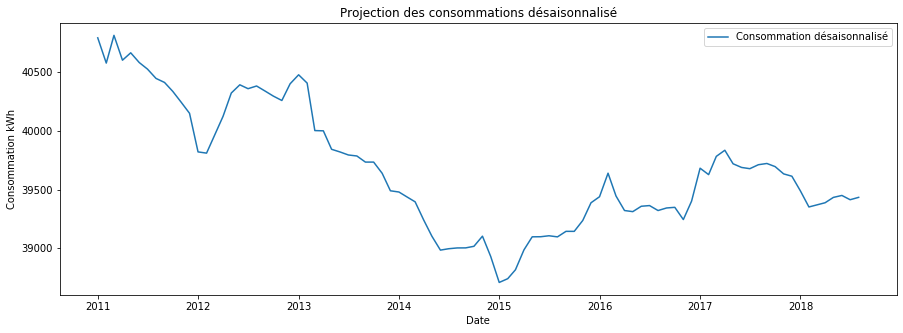

In [14]:

#Représentation grahique
plt.figure(figsize=(15,5))
plt.title("Projection des consommations désaisonnalisé")

plt.plot(data_liss,conso_liss,label="Consommation désaisonnalisé")


plt.ylabel("Consommation kWh")
plt.xlabel("Date")
plt.legend()
plt.savefig(destination_graph+"donnéeDesaiso.png")
plt.show()


In [15]:

#Récupération des données désaisonnalisées
df_ConsoDesaison = pd.DataFrame({"Date":data_liss,"Consommation":conso_liss})
df_ConsoDesaison.set_index("Date", inplace=True)
df_ConsoDesaison.head()


,Consommation
Date,
2011-01-01,40790.714
2011-02-01,40575.810
2011-03-01,40811.734
2011-04-01,40600.314
2011-05-01,40663.213


On a essayé plusieurs versions intégrées à des librairies par la suite

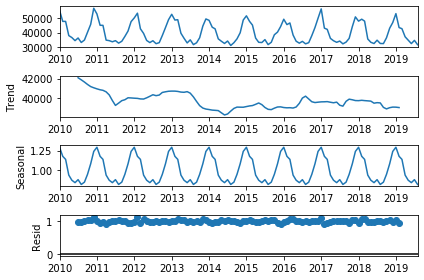

In [16]:

#Version utilisée dans le cours
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

df_desai_stat = seasonal_decompose(df_ConsoMensuFrance_Corriger,  model='multiplicative')
df_desai_stat.plot()
plt.savefig(destination_graph+"donnéeDesaisov2.png")
plt.show()


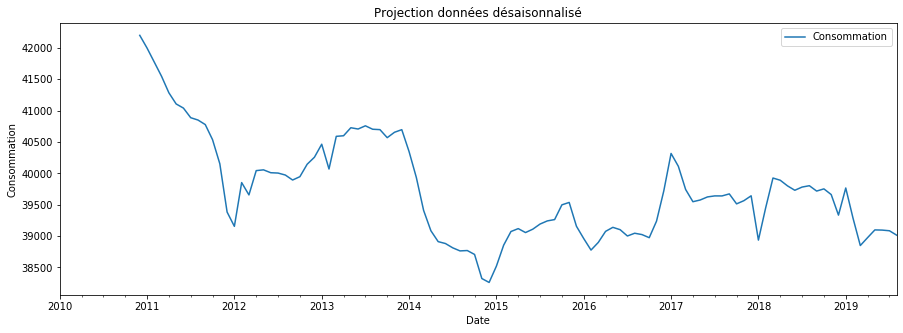

In [17]:

#Version intégrée à pandas
df_desai_pandas = df_ConsoMensuFrance_Corriger.rolling(window=12)
df_desai_pandas.mean().plot(figsize=(15,5))
plt.title("Projection données désaisonnalisé")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.savefig(destination_graph+"donnéeBrut.png")
plt.show()



Notre programme fait un travail similaire à celui des fonctions intégrées donc on peut en conclure qu'il doit fonctionner.



# Mission 3
## Prédiction
__Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle.__


Nous avons divisé cette mission de prédiction en deux parties.
Pour commencer dans cette mission, nous devons prédire la consommation électrique en France sur 1 an après nos données.

Nous allons dans un premier temps utiliser la méthode de Holt-Winter, puis un modèle SARIMA.


In [18]:

def get_stationarity(timeseries):
    
    # Statistiques mobiles
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # tracés statistiques mobiles
    original = plt.plot(timeseries, color='blue', label='Origine')
    mean = plt.plot(rolling_mean, color='red', label='Moyenne Mobile')
    std = plt.plot(rolling_std, color='black', label='Ecart-type Mobile')
    plt.legend(loc='best')
    plt.title('Moyenne et écart-type Mobiles')
    plt.show(block=False)
    
    # Test Dickey–Fuller :
    #l’hypothèse nulle est que la série n’est pas stationnaire
    result = adfuller(timeseries['Consommation'])
    print('Statistiques ADF : {} \n'.format(result[0]))
    print('Test Dickey–Fuller \n --> p-value : {}'.format(result[1]))
    print(f' ---> Resultat: La serie est {"non " if result[1] > 0.05 else ""}stationaire')
    print('\n Valeurs Critiques :')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
        

        


Aide mémoire.

Plus la valeur de *p* est petite, plus la probabilité de faire une erreur en rejetant l'hypothèse nulle est faible. Une valeur limite de 0,05 est souvent utilisée. Autrement dit, vous pouvez rejeter l'hypothèse nulle si la valeur de *p* est inférieure à 0,05.



Mais avant de nous lancer dans nos prédictions, testons notre série temporelle, dans l'étude des séries temporelles la stationnarité de la série est importante. 


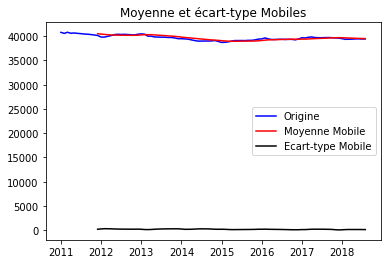

Statistiques ADF : -1.7874957519255068 

Test Dickey–Fuller 
 --> p-value : 0.38668713857940623
 ---> Resultat: La serie est non stationaire

 Valeurs Critiques :
	1%: -3.505190196159122
	5%: -2.894232085048011
	10%: -2.5842101234567902


In [19]:
#test série désaisonnalisée
get_stationarity(df_ConsoDesaison)

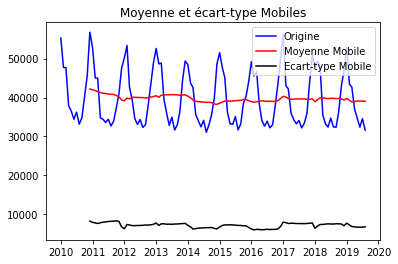

Statistiques ADF : -3.3861569654168773 

Test Dickey–Fuller 
 --> p-value : 0.011439929676770384
 ---> Resultat: La serie est stationaire

 Valeurs Critiques :
	1%: -3.4948504603223145
	5%: -2.889758398668639
	10%: -2.5818220155325444


In [20]:
#test série corrigée de l'effet température
get_stationarity(df_ConsoMensuFrance_Corriger)


Au vu de nos tests, on peut assurément dire que la série corrigée de l'effet température est stationnaire, tandis que notre série désaisonnalisée ne l'est pas.

Nous utiliserons donc les données de la série corrigée de l'effet température, parce qu'un lissage exponentiel n'a vraiment d'intérêt que pour des données (à peu près) stationnaires.



Pourquoi la stationnarité est-elle importante ?

Il est plus simple de faire des prédictions sur une série s'il est possible de supposer que les futures propriétés statistiques (moyenne, variance, covariance) ne seront pas différentes de celles actuellement observées.
La stationnarité de notre série nous indique que les propriétés statistiques de notre série ne varient pas dans le temps.



## Partie 1 : Holt-winter

Prédiction sur 12 mois de nos données corrigées de l'effet température.


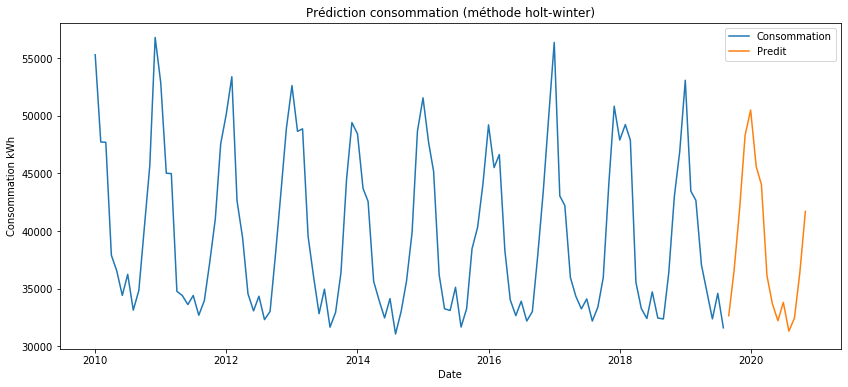

In [21]:

# Prédiction 1 an
# Données désaisonnalisées
serie_temporel = df_ConsoMensuFrance_Corriger

# Temps à prédire (Ici 15 mois, pour finir nos données de 2019 et prédire 2020)
periode_pred = 15

hw = ExponentialSmoothing(np.asarray(serie_temporel['Consommation']), seasonal_periods=12, trend='mul', seasonal='mul').fit()
hw_pred = hw.forecast(periode_pred)

plt.figure(figsize=(14,6))
plt.plot(serie_temporel['Consommation'], label='Consommation')
plt.plot(pd.date_range(serie_temporel.index[len(serie_temporel)-1], periods=periode_pred, freq='M'), hw_pred, label='Predit')
plt.title("Prédiction consommation (méthode holt-winter)")
plt.ylabel("Consommation kWh")
plt.xlabel("Date")
plt.legend()
plt.savefig(destination_graph+"prédiHoltWinter.png")
plt.show()



## Partie 2 : SARIMA

Prédiction sur 12 mois de nos données corrigées de l'effet température, avec un modèle SARIMA


In [22]:

def plot_sortie_acf( y_acf, y_len, pacf=False):
    "représentation de la sortie ACF"
    if pacf:
        y_acf = y_acf[1:]
    plt.figure(figsize=(14,6))
    plt.bar(range(len(y_acf)), y_acf, width = 0.1)
    plt.xlabel('lag')
    plt.ylabel('ACF')
    plt.axhline(y=0, color='black')
    plt.axhline(y=-1.96/np.sqrt(y_len), color='b', linestyle='--', linewidth=0.8)
    plt.axhline(y=1.96/np.sqrt(y_len), color='b', linestyle='--', linewidth=0.8)
    plt.ylim(-1, 1)
    plt.show()
    return


/home/owen/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


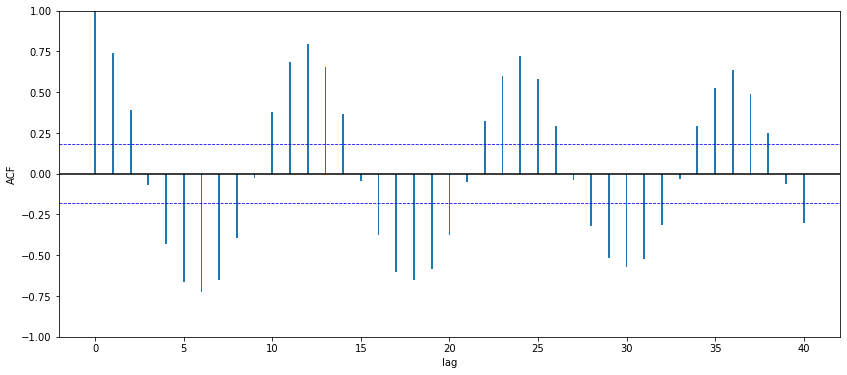

In [23]:

serie_temporel = df_ConsoMensuFrance_Corriger

# variable nécessaire pour l'utilisation de plot_sortie_acf
y_len = len(serie_temporel['Consommation']) 

plot_sortie_acf(acf(np.asarray(serie_temporel['Consommation'])), y_len)


/home/owen/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


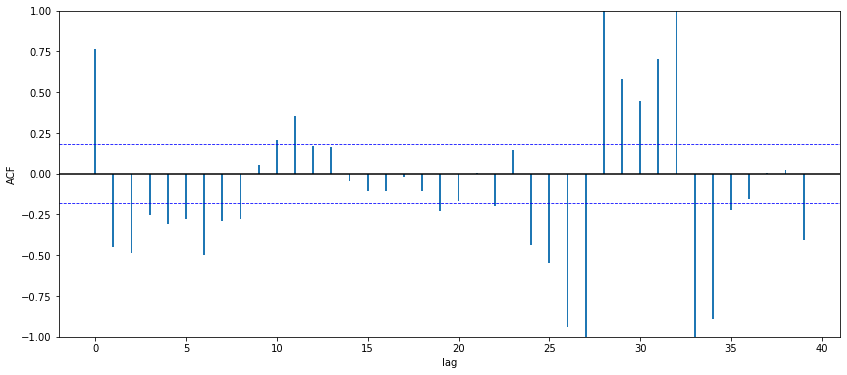

In [24]:
plot_sortie_acf(pacf(np.asarray(serie_temporel['Consommation'][13:])), y_len, pacf=True)


p --> 1, on descend vite a 0 (graphe 1)

d --> 0, car notre série est stationnaire

q --> 1, on descend vite a 0 (graphe 2)



On estime en premier lieu un modèle $SARIMA(1,0,1)(1,0,1)_{12}$ au vu des auto-corrélogrammes empiriques simples et partiels


In [25]:

model = SARIMAX(np.asarray(df_ConsoMensuFrance_Corriger['Consommation']), order=(1,0,1), seasonal_order=(1,0,1,12))
results = model.fit()
print(results.summary())

print('Test de ljung-box(q) des residut \n Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results.resid, lags=elt,return_df =False)[1].mean()))
    

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  116
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood               -1096.262
Date:                            Mon, 15 Jun 2020   AIC                           2202.525
Time:                                    21:02:34   BIC                           2216.293
Sample:                                         0   HQIC                          2208.114
                                            - 116                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9820      0.083     11.766      0.000       0.818       1.146
ma.L1         -0.5351      0.170   

Tout les  P>|z| sont inférieurs à 0.05

De plus, nous ne pouvons pas rejeter h0 pour les tests de ljungbox sur les résidus

Les tests de significativité des paramètres et de blancheur du résidu sont validés au niveau 5%.

In [26]:

#hypothèse nulle h0 est que la population est normalement distribuée

st.shapiro(results.resid)


(0.4717097282409668, 1.3709051441454918e-18)

Le test de normalité est également validé pour ce modèle.

Les résidus sont bien un bruit blanc normalement distribué.

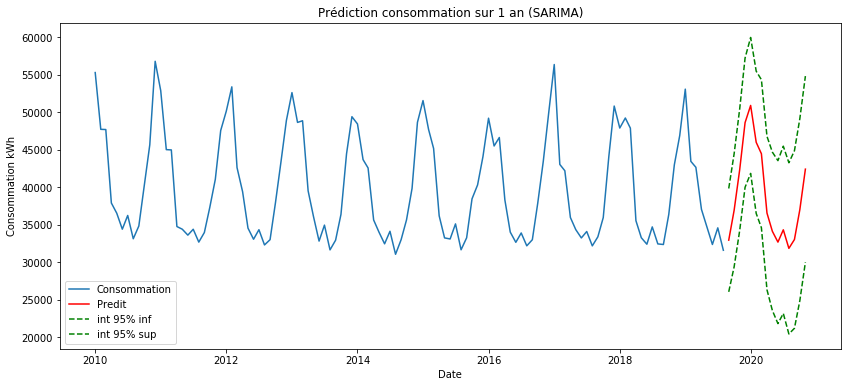

In [27]:

#prédiction grâce à SARIMA
temp_predit = 15

pred_model = results.get_forecast(temp_predit)
pred = pred_model.predicted_mean


pred_l = [elt[0] for elt in pred_model.conf_int(alpha=0.05)]
pred_u = [elt[1] for elt in pred_model.conf_int(alpha=0.05)]

plt.figure(figsize=(14,6))
plt.plot(df_ConsoMensuFrance_Corriger['Consommation'], label='Consommation')
plt.plot(pd.date_range(df_ConsoMensuFrance_Corriger.index[len(df_ConsoMensuFrance_Corriger)-1], periods=temp_predit, freq='M'), pred, color='r', label='Predit')
plt.plot(pd.date_range(df_ConsoMensuFrance_Corriger.index[len(df_ConsoMensuFrance_Corriger)-1], periods=temp_predit, freq='M'), pred_l, color='g', linestyle='--',  label="int 95% inf")
plt.plot(pd.date_range(df_ConsoMensuFrance_Corriger.index[len(df_ConsoMensuFrance_Corriger)-1], periods=temp_predit, freq='M'), pred_u, color='g', linestyle='--',  label="int 95% sup")

plt.title("Prédiction consommation sur 1 an (SARIMA)")
plt.ylabel("Consommation kWh")
plt.xlabel("Date")
plt.legend()
plt.savefig(destination_graph+"sarima1.png")
plt.show()


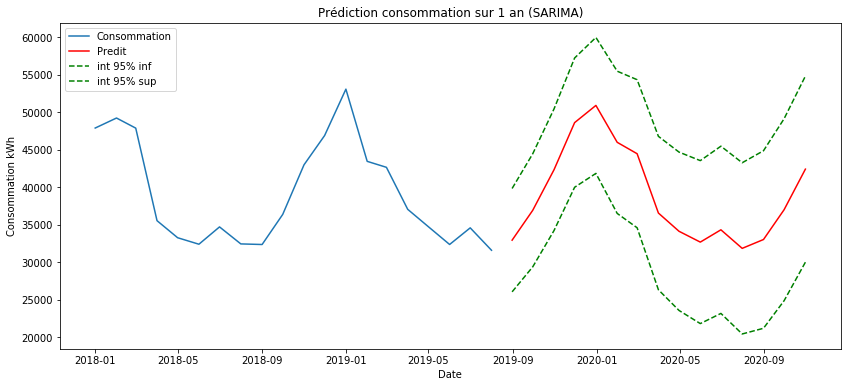

In [28]:

plt.figure(figsize=(14,6))
plt.plot(df_ConsoMensuFrance_Corriger['Consommation']['2018':], label='Consommation')

plt.plot(pd.date_range(df_ConsoMensuFrance_Corriger.index[len(df_ConsoMensuFrance_Corriger)-1], periods=temp_predit, freq='M'), pred, color='r', label='Predit')
plt.plot(pd.date_range(df_ConsoMensuFrance_Corriger.index[len(df_ConsoMensuFrance_Corriger)-1], periods=temp_predit, freq='M'), pred_l, color='g', linestyle='--', label="int 95% inf")
plt.plot(pd.date_range(df_ConsoMensuFrance_Corriger.index[len(df_ConsoMensuFrance_Corriger)-1], periods=temp_predit, freq='M'), pred_u, color='g', linestyle='--', label="int 95% sup")
plt.title("Prédiction consommation sur 1 an (SARIMA)")
plt.ylabel("Consommation kWh")
plt.xlabel("Date")
plt.legend()
plt.savefig(destination_graph+"sarima2.png")
plt.show()



Nous avons donc notre modèle, mais est-il bon, ces prédictions peuvent, elles être utilisables ?

Pour vérifier cela, nous "retirons" une année de nos données et nous allons les prédire.


In [29]:

x_tronc = df_ConsoMensuFrance_Corriger[:'2017']
x_a_prevoir = df_ConsoMensuFrance_Corriger['2018':]


In [30]:

model1tronc = SARIMAX(np.asarray(x_tronc['Consommation']), order=(1,0,1), seasonal_order=(1,0,1,12))
results1tronc = model1tronc.fit()
print(results1tronc.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results1tronc.resid, lags=elt,return_df =False)[1].mean()))
    
st.shapiro(results1tronc.resid)


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -899.155
Date:                            Mon, 15 Jun 2020   AIC                           1808.311
Time:                                    21:02:36   BIC                           1821.132
Sample:                                         0   HQIC                          1813.493
                                             - 96                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.000   2604.359      0.000       0.999       1.000
ma.L1         -0.8998      0.060   

/home/owen/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(0.5155575275421143, 2.994113767173774e-16)

Notre modèle est toujours valide

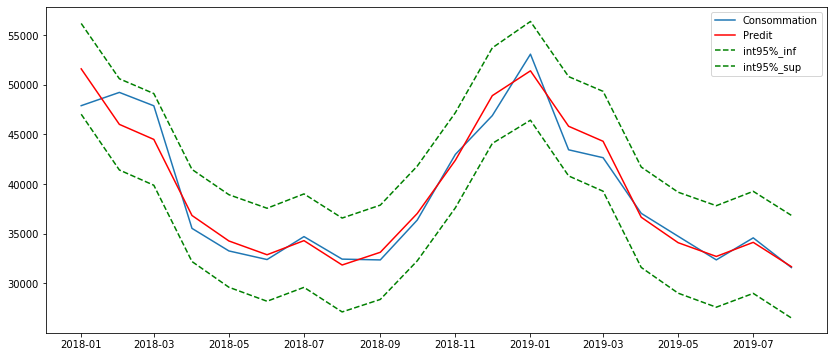

In [31]:

pred_model1tronc = results1tronc.get_forecast(20)
pred_tronc = pred_model1tronc.predicted_mean
pred_l_tronc = [elt[0] for elt in pred_model1tronc.conf_int(alpha=0.05)]
pred_u_tronc = [elt[1] for elt in pred_model1tronc.conf_int(alpha=0.05)]

plt.figure(figsize=(14,6))
plt.plot(x_a_prevoir, label='Consommation')
plt.plot(x_a_prevoir.index, pred_tronc, color='r', label='Predit')
plt.plot(x_a_prevoir.index, pred_l_tronc, color='g', linestyle='--', label='int95%_inf')
plt.plot(x_a_prevoir.index, pred_u_tronc, color='g', linestyle='--', label='int95%_sup')
plt.legend()
plt.savefig(destination_graph+"pred20182019.png")
plt.show()



Ici, notre prédiction de l'année 2018, grâce aux données depuis 2010 est très proche des données relevées. De plus notre intervalle de confiance à 95 % contient toujours nos données.


In [32]:
rmse = np.sqrt(((x_a_prevoir['Consommation']-pred_tronc)**2).mean())
rmse

1679.601940474946


Ici, l'erreur quadratique moyenne se mesurera sur la consommation ,donc en kWh, notre RMSE n'est pas excessif.


In [33]:
mape=(np.abs(1-pred_tronc/x_a_prevoir['Consommation'])).mean()*100
mape

3.0183151914016193


Nous avons un MAPE(pourcentage d'erreur absolue moyen) de 3.02 % ce qui est satisfaisant à priori.


# Conclusion

Notre modèle parvient à prédire des consommations plutôt juste, et les erreurs qui en ressortes sont assez minimes.
Je pense donc que nous pouvons faire confiance à ce modèle. 

Axe d'amélioration :
- Faire une étude et prédiction par région (plus de précision)
- Trouver un modèle plus précis ?
- Étude de la capacité de production de nos énergies vertes pour les coupler avec cette étude.